## Выбор модели для задач классификации

Для задач классификации существует несколько способов выбора модели:

1. **Обучить маленькую модель с нуля**: Выбор легковесной архитектуры модели и полное обучение её на нашем наборе данных.
2. **Fine-Tuning предобученной модели**: Используем модель, которая была предобучена авторами на другом наборе данных, и только последние слои переобучается на нашем конкретном наборе данных.
3. **Использовать предобученные веса напрямую**: В этом методе используется предобученная модель без дополнительного обучения.

Лучшим вариантом является Fine-Tuning, поэтому в качестве бейзлайна возьмем маленькую (5.3M) EfficientNet B0 с претрейновыми параметрами

[Оригинальная статья](https://arxiv.org/abs/1905.11946)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import zipfile
import json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# drive.flush_and_unmount()

In [5]:
# Загрузка гиперпараметров из JSON (создайте папку classification, если её еще нет в корне диска Google Drive)
with open('/content/drive/MyDrive/classification/hyperparams.json', "r") as f:
  hyperparams = json.load(f)

In [6]:
# Загрузка названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx.json", "r")  as f:
  class_to_idx = json.load(f)


**Структура** c*lassification_dataset.zip*: (внутри папка с таким же названием)

```
classification_dataset/
├── train/
│   ├── class_name1/
│   └── class_name2/
│   └── ...

└── test/
    ├── class_name1/
    └── class_name2/
    └── ...
```



In [7]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [8]:
# Класс для аугментации данных
class AugmentedDataset(Dataset):
    def __init__(self, original_folder, target_size=50, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = class_to_idx

        # Проверяем, что все классы из JSON есть в папке
        class_names = os.listdir(original_folder)
        missing_classes = [cls for cls in class_to_idx.keys() if cls not in class_names]
        if missing_classes:
            raise ValueError(f"Классы {missing_classes} из class_to_idx.json отсутствуют в папке {original_folder}")

        # Собираем пути к изображениям для каждого класса
        for class_name in class_names: # Используем отсортированные имена классов
            class_path = os.path.join(original_folder, class_name)
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            # Повторяем изображения до достижения целевого размера
            for i in range(target_size):
                self.samples.append((images[i % len(images)], class_name))

    # Возвращает общее количество элементов в наборе данных
    def __len__(self):
        return len(self.samples)

    # Возвращает одно изображение и его метку по индексу
    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        # Преобразуем метку класса в числовой формат
        label = self.class_to_idx[class_name]  # Преобразуем имя класса в индекс
        return image, label  # Оставляем числовую метку для обучения

In [9]:
# Класс для создания датасета под Test выборку
class TestDataset(Dataset):
    def __init__(self, original_folder, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = class_to_idx  # Загружаем метки классов из JSON

        # Проверяем, что все классы из JSON есть в папке
        class_names = os.listdir(original_folder)
        missing_classes = [cls for cls in class_to_idx.keys() if cls not in class_names]
        if missing_classes:
            raise ValueError(f"Классы {missing_classes} из class_to_idx.json отсутствуют в {original_folder}")

        # Собираем пути к изображениям
        for class_name in class_names:
            class_path = os.path.join(original_folder, class_name)
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            for img_path in images:
                self.samples.append((img_path, class_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        # Применяем трансформации (без аугментаций)
        if self.transform:
            image = self.transform(image)

        # Преобразуем имя класса в индекс
        label = self.class_to_idx[class_name]
        return image, label

In [10]:
def create_dataloaders(
    train_dir,
    test_dir,
    hyperparams,
    target_size=50
):
    """
    Создает DataLoader'ы для обучающих и тестовых данных.

    Args:
        train_dir: Путь к папке с обучающими данными.
        test_dir: Путь к папке с тестовыми данными.
        hyperparams: Словарь с гиперпараметрами, включая 'batch_size'.
        target_size: Целевой размер для аугментации данных.
        train_transform: Трансформации для обучающих данных.
        test_transform: Трансформации для тестовых данных.

    Returns:
        train_loader, test_loader: DataLoader'ы для обучающих и тестовых данных.
    """

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Создание аугментированных датасетов
    train_dataset = AugmentedDataset(
        original_folder=train_dir,
        target_size=target_size,
        transform=train_transform
    )

    test_dataset = TestDataset(
        original_folder=test_dir,
        transform=test_transform
    )

    # DataLoader'ы
    train_loader = DataLoader(
        train_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=False
    )

    return train_loader, test_loader, train_dataset, test_dataset

In [11]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50
)

In [12]:
# Проверим классы
test_dataset.class_to_idx

{'dog': 0, 'cat': 1}

In [13]:
# Создание обратного словаря idx_to_class
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [14]:
# Загрузка модели EfficientNet
model = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

### Фунция для расчета метрик классификации

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [49]:
def evaluate_model(model, data_loader, criterion, device):
  """
  Оценивает модель, возвращая словарь различных метрик
  (Accuracy, f1_Score, precision, recall etc.)
  """
  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item() * images.size(0)

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

    # Расчет метрик

    accuracy = correct / total
    avg_loss = val_loss / len(data_loader.dataset)


    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    class_report = classification_report(all_labels, all_preds, zero_division=0, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'class_report': class_report,
        'confusion_matrix': conf_matrix,
        'predictions': all_preds,
        'ground_truth': all_labels
    }



### Функции для визуализации

In [18]:
import seaborn as sns

In [19]:
def plot_training_history(train_metrics, val_metrics, metric_name='loss'):
    """
    Строит графики выбранной метрики на протяжении эпох обучения.

    Args:
        train_metrics: Список значений метрики на обучающей выборке
        val_metrics: Список значений метрики на валидационной выборке
        metric_name: Название метрики для отображения
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'b-', label=f'Тренировка {metric_name}')
    plt.plot(epochs, val_metrics, 'r-', label=f'Валидация {metric_name}')

    plt.title(f'Тренировка и валидация {metric_name.capitalize()}')
    plt.xlabel('Эпохи')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm, class_names):
    """
    Визуализирует матрицу ошибок.

    Args:
        cm: Матрица ошибок
        class_names: Список названий классов
    """
    plt.figure(figsize=(10, 8))

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Нормализованная матрица ошибок')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_dataset, idx_to_class, device, num_samples=10):
    """
    Визуализирует предсказания модели на тестовых примерах.

    Args:
        model: Обученная модель
        test_dataset: Тестовый датасет
        idx_to_class: Словарь для преобразования индекса класса в название
        device: Устройство для выполнения вычислений
        num_samples: Количество примеров для визуализации
    """
    model.eval()

    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(2, num_samples // 2, figsize=(20, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        image, label = test_dataset[idx]

        img = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            _, predicted = torch.max(output, 1)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence = probabilities[0][predicted[0]].item()

        axes[i].imshow(img)
        title_color = 'green' if predicted[0].item() == label else 'red'

        axes[i].set_title(f"Predicted: {idx_to_class[predicted[0].item()]}\n"
                         f"True: {idx_to_class[label]}\n"
                         f"Conf: {confidence:.2f}", color=title_color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_class_distribution(train_dataset, test_dataset, idx_to_class):
    """
    Визуализирует распределение классов в обучающем и тестовом наборах.
    """
    train_counts = {}
    test_counts = {}

    for _, label_name in train_dataset.samples:
        label = train_dataset.class_to_idx[label_name]
        train_counts[label] = train_counts.get(label, 0) + 1

    for _, label_name in test_dataset.samples:
        label = test_dataset.class_to_idx[label_name]
        test_counts[label] = test_counts.get(label, 0) + 1

    class_indices = sorted(idx_to_class.keys())
    class_names = [idx_to_class[i] for i in class_indices]

    train_values = [train_counts.get(i, 0) for i in class_indices]
    test_values = [test_counts.get(i, 0) for i in class_indices]

    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(class_indices))
    width = 0.35

    ax.bar(x - width/2, train_values, width, label='Train')
    ax.bar(x + width/2, test_values, width, label='Test')

    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_title('Распределение классов в наборах данных')
    ax.set_ylabel('Количество изображений')
    ax.legend()

    plt.tight_layout()
    plt.show()

### Обучение модели

In [20]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_f1': [],
        'precision': [],
        'recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / train_total

        metrics = evaluate_model(model, test_loader, criterion, device)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(metrics['loss'])
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(metrics['accuracy'])
        history['val_f1'].append(metrics['f1_score'])

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(
            f"Val Loss: {metrics['loss']:.4f}, Val Acc: {metrics['accuracy']:.4f}, Val F1: {metrics['f1_score']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}"
            )
        print('-' * 60)

    return history, model

In [21]:
efficientnet_b0_history_50, efficientnet_b0_50 = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

Epoch 1/10
Train Loss: 0.6836, Train Acc: 0.5100
Val Loss: 0.6534, Val Acc: 0.6110, Val F1: 0.5425, Precision: 0.7769, Recall: 0.6110
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6371, Train Acc: 0.6700
Val Loss: 0.6182, Val Acc: 0.8340, Val F1: 0.8309, Precision: 0.8607, Recall: 0.8340
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.6008, Train Acc: 0.8500
Val Loss: 0.5929, Val Acc: 0.8590, Val F1: 0.8575, Precision: 0.8749, Recall: 0.8590
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.5568, Train Acc: 0.9200
Val Loss: 0.5556, Val Acc: 0.9040, Val F1: 0.9039, Precision: 0.9057, Recall: 0.9040
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.4939, Train Acc: 0.9400
Val Loss: 0.5159, Val Acc: 0.9050, Val F1: 0.9050, Precision: 0.9050, Recall: 0.9050
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [22]:
efficientnet_b0_metrics_50 = evaluate_model(efficientnet_b0_50, test_loader, criterion, device)

In [23]:
efficientnet_b0_metrics_50["confusion_matrix"]

array([[455,  45],
       [ 35, 465]])

Довольно много примеров модель угадывает правильно даже при малом кол-ве сэмплов ( всего 50 на каждый класс )

In [24]:
efficientnet_b0_metrics_50["class_report"]

{'0': {'precision': 0.9285714285714286,
  'recall': 0.91,
  'f1-score': 0.9191919191919192,
  'support': 500.0},
 '1': {'precision': 0.9117647058823529,
  'recall': 0.93,
  'f1-score': 0.9207920792079208,
  'support': 500.0},
 'accuracy': 0.92,
 'macro avg': {'precision': 0.9201680672268908,
  'recall': 0.92,
  'f1-score': 0.91999199919992,
  'support': 1000.0},
 'weighted avg': {'precision': 0.9201680672268908,
  'recall': 0.92,
  'f1-score': 0.9199919991999199,
  'support': 1000.0}}

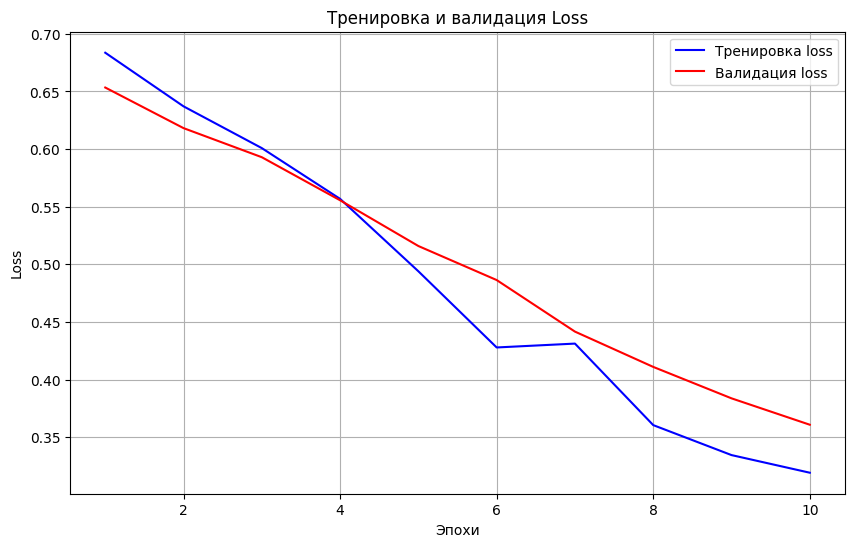

In [25]:
plot_training_history(efficientnet_b0_history_50['train_loss'], efficientnet_b0_history_50['val_loss'], 'loss')

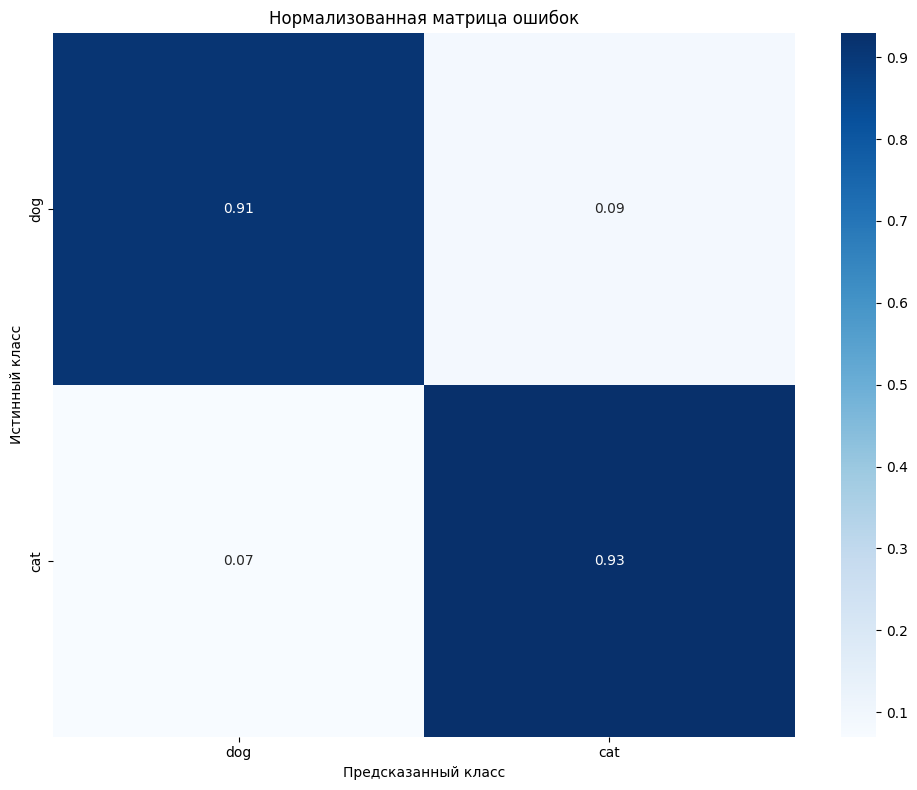

In [26]:
plot_confusion_matrix(efficientnet_b0_metrics_50["confusion_matrix"], idx_to_class.values())

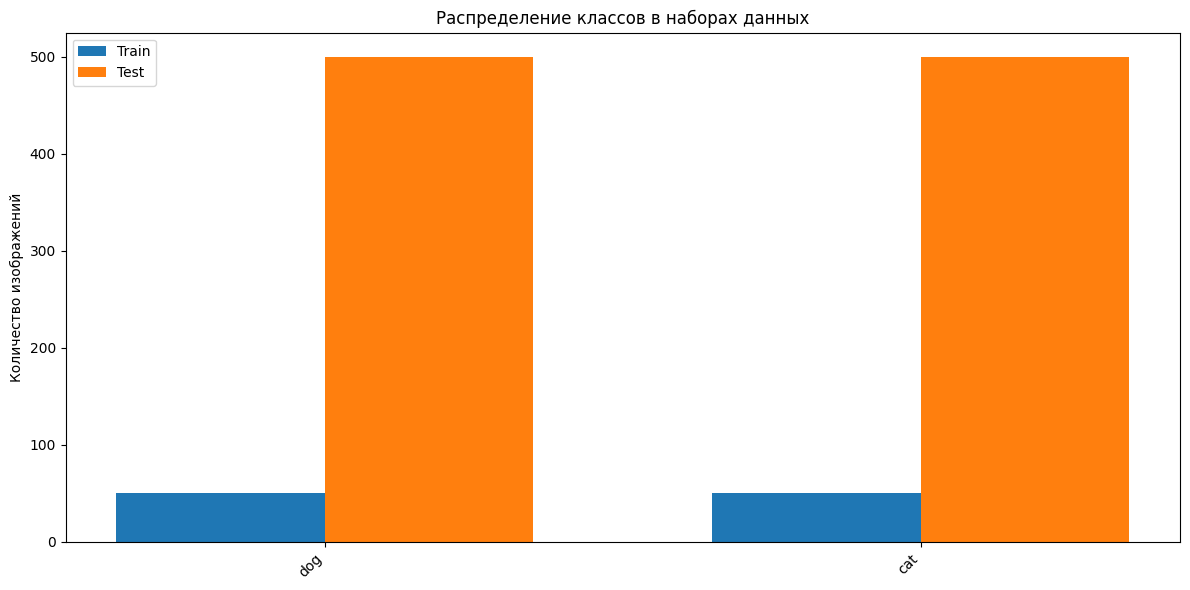

In [27]:
plot_class_distribution(train_dataset, test_dataset, idx_to_class)

In [28]:
benchmarks = {
    "efficientnet_b0_50": efficientnet_b0_metrics_50
}

Модель показывает отличные матрики на совсем малом кол-ве изображений в тренировочном датасете, попробуем снизить их до минимального кол-ва (15) по каждому из классов

*Сделаем замечание, что EfficentNet обучалась на датасете ImageNet, в котором уже присутсвовали данные классы, дальше попробуем обучаться на незнакомых модели классах*

In [29]:
import shutil

shutil.rmtree('/content/dataset')

In [30]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset_small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [31]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50
)

In [32]:
# Загрузка модели EfficientNet
model = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [38]:
efficientnet_b0_history_15, efficientnet_b0_15 = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

Epoch 1/10
Train Loss: 0.6678, Train Acc: 0.6200
Val Loss: 0.6406, Val Acc: 0.7790, Val F1: 0.7697, Precision: 0.8328, Recall: 0.7790
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6014, Train Acc: 0.9300
Val Loss: 0.6087, Val Acc: 0.8860, Val F1: 0.8860, Precision: 0.8860, Recall: 0.8860
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5332, Train Acc: 0.9400
Val Loss: 0.5846, Val Acc: 0.8770, Val F1: 0.8768, Precision: 0.8793, Recall: 0.8770
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.4826, Train Acc: 0.9600
Val Loss: 0.5457, Val Acc: 0.8830, Val F1: 0.8826, Precision: 0.8877, Recall: 0.8830
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.4196, Train Acc: 0.9300
Val Loss: 0.5089, Val Acc: 0.8960, Val F1: 0.8960, Precision: 0.8962, Recall: 0.8960
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [50]:
efficientnet_b0_metrics_15 = evaluate_model(efficientnet_b0_15, test_loader, criterion, device)

In [51]:
efficientnet_b0_metrics_15["confusion_matrix"]

array([[426,  74],
       [ 33, 467]])

In [52]:
efficientnet_b0_metrics_15["class_report"]

{'0': {'precision': 0.9281045751633987,
  'recall': 0.852,
  'f1-score': 0.8884254431699687,
  'support': 500.0},
 '1': {'precision': 0.8632162661737524,
  'recall': 0.934,
  'f1-score': 0.8972142170989433,
  'support': 500.0},
 'accuracy': 0.893,
 'macro avg': {'precision': 0.8956604206685755,
  'recall': 0.893,
  'f1-score': 0.8928198301344561,
  'support': 1000.0},
 'weighted avg': {'precision': 0.8956604206685757,
  'recall': 0.893,
  'f1-score': 0.892819830134456,
  'support': 1000.0}}

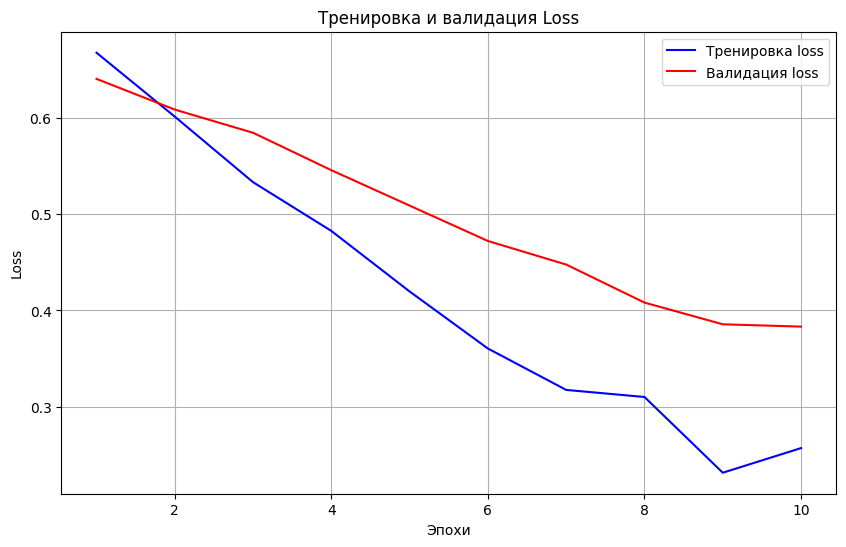

In [42]:
plot_training_history(efficientnet_b0_history_15['train_loss'], efficientnet_b0_history_15['val_loss'], 'loss')

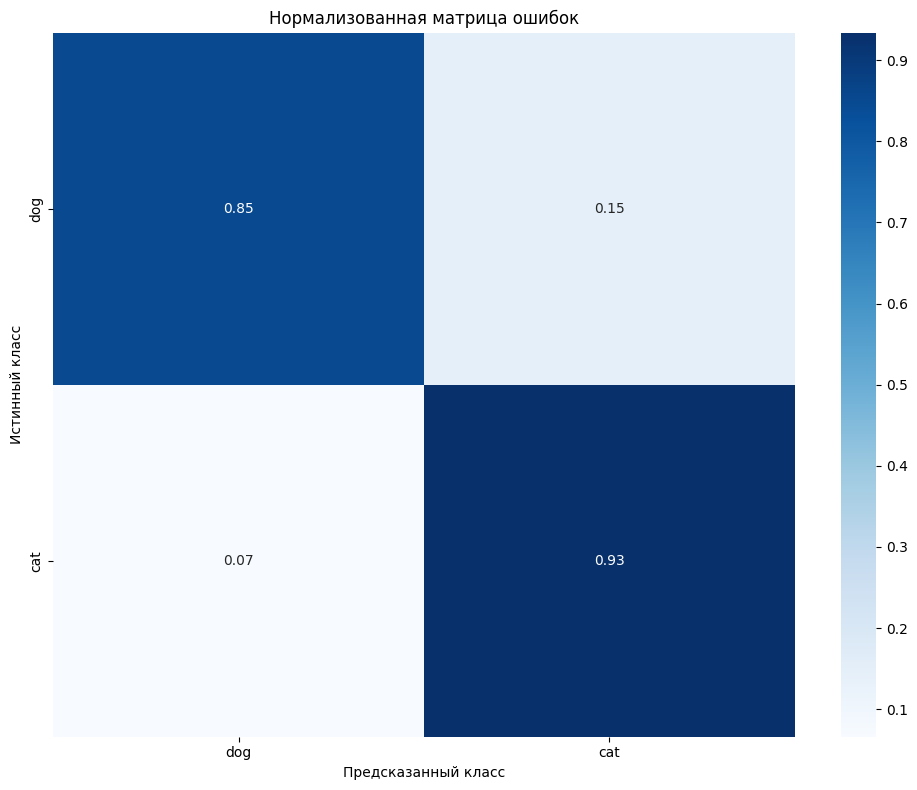

In [43]:
plot_confusion_matrix(efficientnet_b0_metrics_15["confusion_matrix"], idx_to_class.values())

In [44]:
benchmarks["efficientnet_b0_15"] = efficientnet_b0_metrics_15

In [55]:
import pandas as pd

<Figure size 1400x800 with 0 Axes>

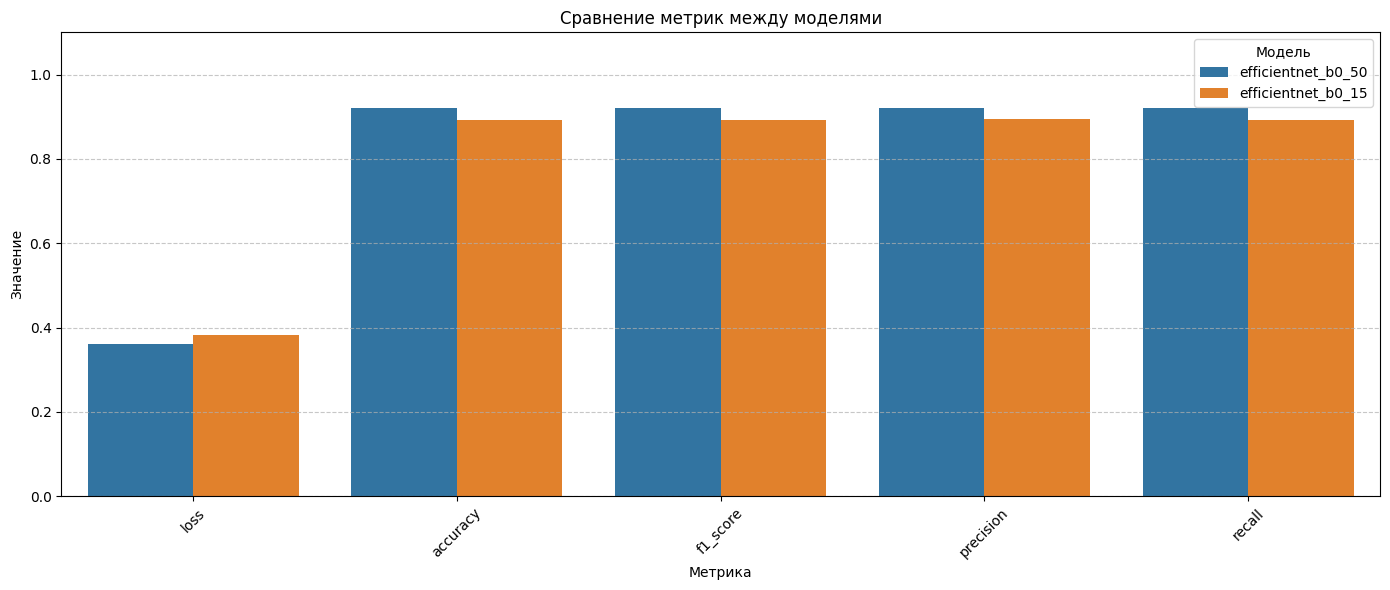

In [61]:
def compare_benchmarks(benchmarks):
    """
    Сравнивает метрики между различными моделями в бенчмарке.

    Args:
        benchmarks: Словарь вида {имя_модели: словарь_метрик}
    """

    first_model = list(benchmarks.keys())[0]
    metrics_to_compare = [metric for metric, value in benchmarks[first_model].items()
                          if isinstance(value, (int, float)) and metric not in ['predictions', 'ground_truth']]

    comparison_data = []
    for model_name, metrics in benchmarks.items():
        model_data = {'Модель': model_name}
        for metric in metrics_to_compare:
            if metric in metrics and isinstance(metrics[metric], (int, float)):
                model_data[metric] = metrics[metric]
        comparison_data.append(model_data)

    df = pd.DataFrame(comparison_data)

    plt.figure(figsize=(14, 8))

    df_melted = df.melt(id_vars=['Модель'], var_name='Метрика', value_name='Значение')

    plt.figure(figsize=(14, 6))
    sns.barplot(x='Метрика', y='Значение', hue='Модель', data=df_melted)
    plt.title('Сравнение метрик между моделями')
    plt.ylabel('Значение')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()

    return None

comparison_df = compare_benchmarks(benchmarks)

Результаты немного ниже, теперь попробуем взять незнакомые классы

In [ ]:
# Сохранение модели
torch.save(model, '/content/trained_model_classification.pt')

# Копирование на Google Drive
!cp "/content/trained_model_classification.pt" "/content/drive/MyDrive/classification/trained_model_classification.pt"
print("Модель сохранена")